## *This is just a CLEANED UP, STREAMLINED version of the notebooks in the CTCF and FOSL2 folders in this directory!*

# Compare the motifs (the CWMs and hCWMs) and motif instance calls between CUTnRUN and ChIPseq
## How do the motif instance calls differ? Compare the distribution of the motif instance calls and see if there's a difference that can be explained by:
* Overlap with DNase-seq peaks
* Overlap with ATAC-seq peaks
* Correlation with ATAC-seq fragment lengths
* Overlap with H3K27ac or H3K4me3 (histone marks)

In [1]:
import os
os.chdir('/home/katie/bp_repo/reports/')

from util import import_shap_scores, import_peak_table
from util import trim_motif_by_ic
from util import figure_to_vdom_image
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from IPython.display import display
import tqdm
tqdm.tqdm_notebook()

plt.rcParams['figure.dpi'] = 130

/tmp/ipykernel_110843/1313173272.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm.tqdm_notebook()


0it [00:00, ?it/s]

In [2]:
# Plotting defaults
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

In [62]:
# set variables
run_date = 'feb7'
keys = ['CTCF_CUTnRUN', 'CTCF_ChIPseq', 'FOSL2_CUTnRUN', 'FOSL2_ChIPseq']
hits_root = '/home/katie/bp_repo/reports/tfm_hits/'

# set motif hits paths      * MAY NEED TO CHANGE THIS *
hits_paths = {'CTCF_CUTnRUN' : [f'{hits_root}CTCF/ctcf_cutnrun_{run_date}/tfm_matches.bed'],
              'CTCF_ChIPseq' : [f'{hits_root}CTCF/ctcf_chipseq_{run_date}/tfm_matches.bed'],
              'FOSL2_CUTnRUN' : [f'{hits_root}FOSL2/fosl2_cutnrun_{run_date}/tfm_matches.bed'],
              'FOSL2_ChIPseq' : [f'{hits_root}FOSL2/fosl2_chipseq_{run_date}/tfm_matches.bed']}

# load in motif hits, core motif hits only, and TA motif hits only  
hits = {}
for key in keys:
    hits[key] = {}
    hits[key]['hits'] = import_peak_table(hits_paths[key])
    hits[key]['core_hits'] = hits[key]['hits'].loc[hits[key]['hits'].name == '0_0', :]
    if 'CUTnRUN' in key:
        hits[key]['TA_hits'] = hits[key]['hits'].loc[hits[key]['hits'].name == '0_1', :]
    
# Load in genomic feature assay peaks
assay_keys = ['ATAC_seq', 'DNase_seq', 'H3K27ac', 'H3K4me3']
assays_root = '/home/katie/bp_repo/research/data/other-assays/A549/'

assays = {'ATAC_seq' : f'{assays_root}ATAC-peaks/ENCFF899OMR.bed.gz',
          'DNase_seq' : f'{assays_root}DNase-peaks/ENCFF128ZVL.bed.gz', 
          'H3K27ac' : f'{assays_root}H3K27ac-histone-marks/ENCFF747IZX.bed.gz', 
          'H3K4me3' : f'{assays_root}H3K4me3-histone-marks/ENCFF535EYL.bed.gz'}

overlap_save_root = '/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_2/hits_overlapping_genomic_features/'

### Run bedtools intersect (only do this once per set of tfm_matches.bed/model run)

In [35]:
for key in keys:
    for assay_key in assay_keys:
        hit = hits_paths[key][0]
        assay = assays[assay_key]
        os.system(f'bedtools intersect -u -a {hit} -b {assay} > {overlap_save_root}{key}/{assay_key}/{run_date}_overlaps.tsv')

### Load in overlap dataframes 

In [43]:
# load in motif hits, core motif hits only, and TA motif hits only (which overlap with the given genomic feature)
overlaps = {}
for key in keys:
    overlaps[key] = {}
    for assay_key in assay_keys:
        overlaps[key][assay_key] = {}
        shortcut = overlaps[key][assay_key]
        shortcut['overlaps'] = import_peak_table([f'{overlap_save_root}{key}/{assay_key}/{run_date}_overlaps.tsv'])
        shortcut['core_overlaps'] = shortcut['overlaps'].loc[shortcut['overlaps'].name == '0_0', :]
        if 'CUTnRUN' in key:
            shortcut['TA_overlaps'] = shortcut['overlaps'].loc[shortcut['overlaps'].name == '0_1', :]

In [12]:
# this only needs to be run once and saved then opened in the future as TSVs
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_cutnrun_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_2/CTCF/cutnrun_motif_hits_atac_overlap')
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_chipseq_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_2/CTCF/chipseq_motif_hits_atac_overlap')

cutnrun_atac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_2/CTCF/cutnrun_motif_hits_atac_overlap',  # 124,368 overlaps
                                sep='\t', header=None)
chipseq_atac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_2/CTCF/chipseq_motif_hits_atac_overlap',  # 76,135 overlaps
                                sep='\t', header=None)

In [13]:
core_cutnrun_atac_overlap = cutnrun_atac_overlap[cutnrun_atac_overlap.iloc[:,3] == '0_0']                # 84,692 core overlaps
core_chipseq_atac_overlap = chipseq_atac_overlap[chipseq_atac_overlap.iloc[:,3] == '0_0']                # 75,769 core overlaps

In [14]:
len(core_cutnrun_atac_overlap) / len(core_hits_cutnrun)  # % of cutnrun task hits overlapping >0 DNase peak ONLY FOR CORE MOTIF

0.8685819855955897

In [15]:
len(core_chipseq_atac_overlap) / len(core_hits_chipseq)  # % of chipseq task hits overlatacg >0 DNase peak ONLY FOR CORE MOTIF

0.8963303391128752

#### ATAC-seq fragment length correlation

In [ ]:
# TODO

In [18]:
# this only needs to be run once and saved then opened in the future as TSVs
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_cutnrun_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_2/CTCF/cutnrun_motif_hits_h3k27ac_overlap')
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_chipseq_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_2/CTCF/chipseq_motif_hits_h3k27ac_overlap')

cutnrun_ac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_2/CTCF/cutnrun_motif_hits_h3k27ac_overlap',  # 94,209 overlaps
                                sep='\t', header=None)
chipseq_ac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/round1_tasks_jan-mar2022/TASK_2/CTCF/chipseq_motif_hits_h3k27ac_overlap',  # 61,455 overlaps
                                sep='\t', header=None)

In [20]:
core_cutnrun_ac_overlap = cutnrun_ac_overlap[cutnrun_ac_overlap.iloc[:,3] == '0_0']                # 62,135 core overlaps
core_chipseq_ac_overlap = chipseq_ac_overlap[chipseq_ac_overlap.iloc[:,3] == '0_0']                # 61,172 core overlaps

In [21]:
len(core_cutnrun_ac_overlap) / len(core_hits_cutnrun)  # % of cutnrun task hits overlapping >0 DNase peak ONLY FOR CORE MOTIF

0.2668767721475217

In [22]:
len(core_chipseq_ac_overlap) / len(core_hits_chipseq)  # % of chipseq task hits overlatacg >0 DNase peak ONLY FOR CORE MOTIF

0.29279298099018175

## Graphing

In [126]:
def plot_overlaps(tf, motif_type, denominator):
    '''
    tf : `CTCF` or `FOSL2`
    motif_type : `core` or `TA` or (rarely) `all`
    denominator : `core` or `TA` or `all`   # referring to ALL of the core hits, ALL of the TA hits, or ALL of the hits! (not just intersecting)
    '''
    
    overlaps_indexing_key = 'overlaps' if motif_type == 'all' else motif_type + '_overlaps'   # for indexing in last "dimension" of overlaps dict
    hits_indexing_key = 'hits' if denominator == 'all' else motif_type + '_hits'   # for indexing in last "dimension" of hits dict (for denominator
                                                                                   # when calculating percentage overlap)
    cutnrun_stats = overlaps[f'{tf}_CUTnRUN']
    cutnrun_stats = list( len(cutnrun_stats[assay][overlaps_indexing_key]) for assay in assay_keys )
    cutnrun_stats = list( round(stat / len(hits[f'{tf}_CUTnRUN'][hits_indexing_key]), 2) for stat in cutnrun_stats )
    
    if motif_type != 'TA':
        chipseq_stats = overlaps[f'{tf}_ChIPseq']
        chipseq_stats = list( len(chipseq_stats[assay][overlaps_indexing_key]) for assay in assay_keys )
        chipseq_stats = list( round(stat / len(hits[f'{tf}_ChIPseq'][hits_indexing_key]), 2) for stat in chipseq_stats )
    
    fig, ax = plt.subplots(dpi=130)
    ind = np.arange(len(cutnrun_stats))  # the x locations for the groups
    width = 0.35 if motif_type != 'TA' else 0.5 # the width of the bars
    
    if motif_type != 'TA':
        rects_cut = ax.bar(ind - width/2, cutnrun_stats, width, label='CUTnRUN model')
        rects_chip = ax.bar(ind + width/2, chipseq_stats, width, label='ChIPseq model')
    else:
        rects_cut = ax.bar(ind, cutnrun_stats, width, label='CUTnRUN model')
        
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(f'% of {denominator} motif hits that overlap', fontsize=13)
    ax.set_title(f'{tf} {motif_type} motif hits\noverlapping genomic features')
    ax.set_xticks(ind)
    ax.set_xticklabels(assay_keys, rotation=30, fontsize=13)
    ax.legend(loc='upper right', fontsize=11)
    ax.set_xlabel(f'* Calculated by dividing # of {motif_type} hits intersecting each feature by\n# of {denominator} hits in general *', fontsize=8)
    
    ax.bar_label(rects_cut, padding=1, fontsize=8)
    if motif_type != 'TA':
        ax.bar_label(rects_chip, padding=1, fontsize=8)

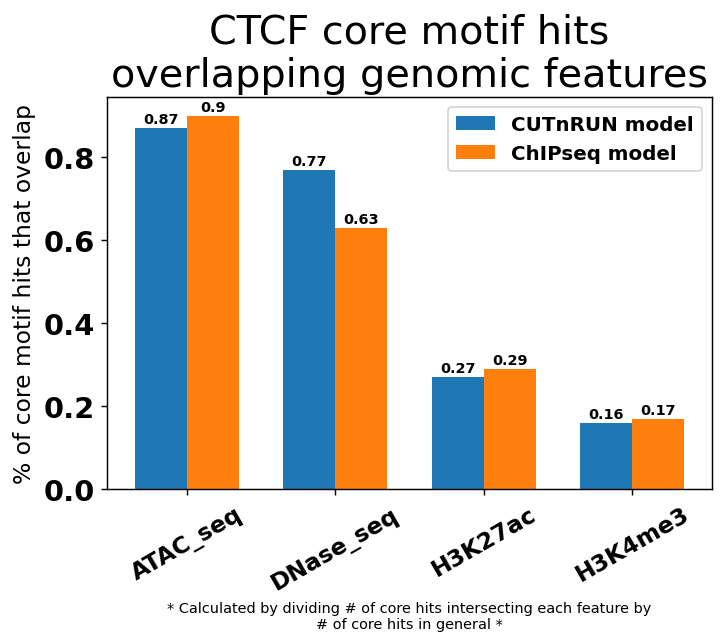

In [127]:
plot_overlaps('CTCF', 'core', 'core')

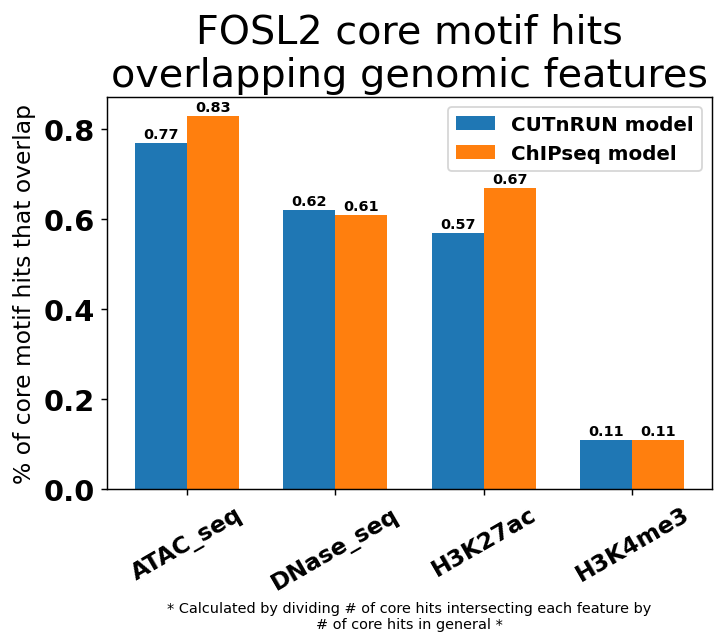

In [128]:
plot_overlaps('FOSL2', 'core', 'core')

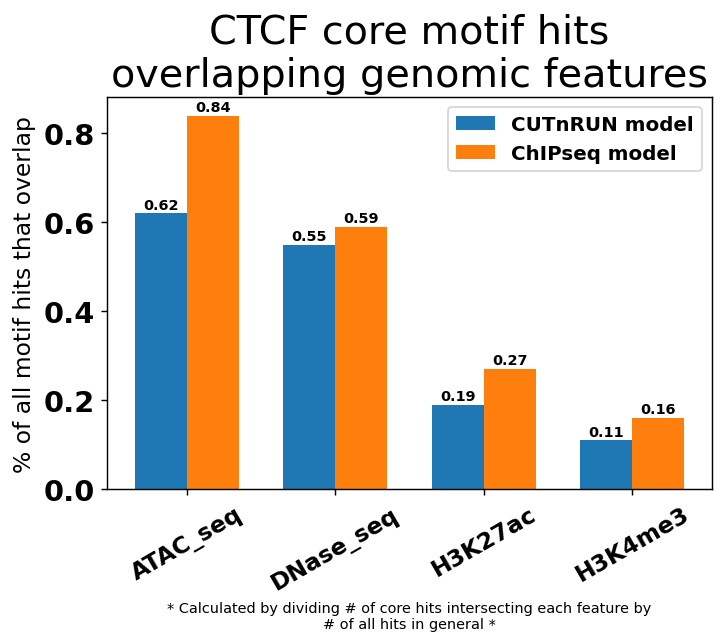

In [129]:
plot_overlaps('CTCF', 'core', 'all')

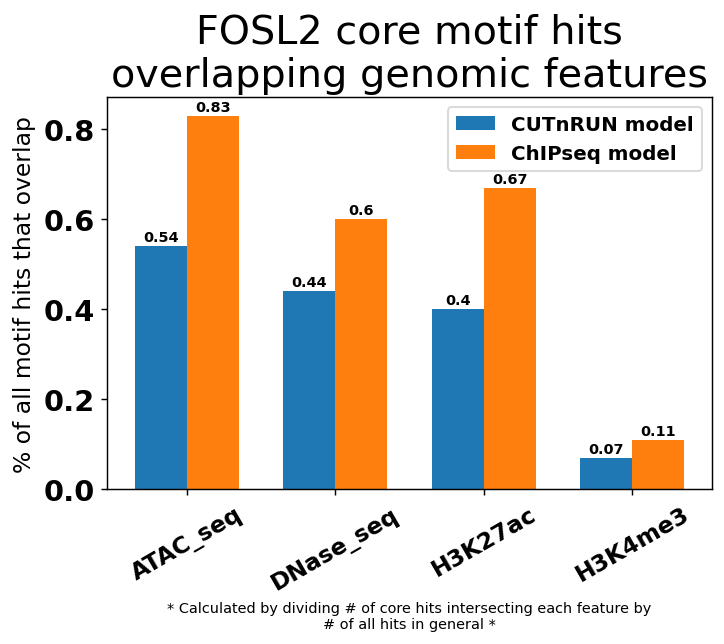

In [130]:
plot_overlaps('FOSL2', 'core', 'all')

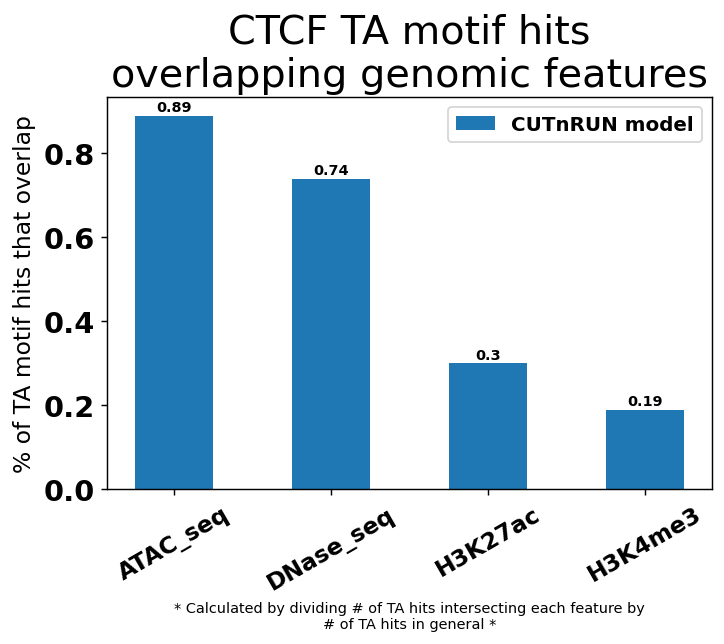

In [131]:
plot_overlaps('CTCF', 'TA', 'TA')

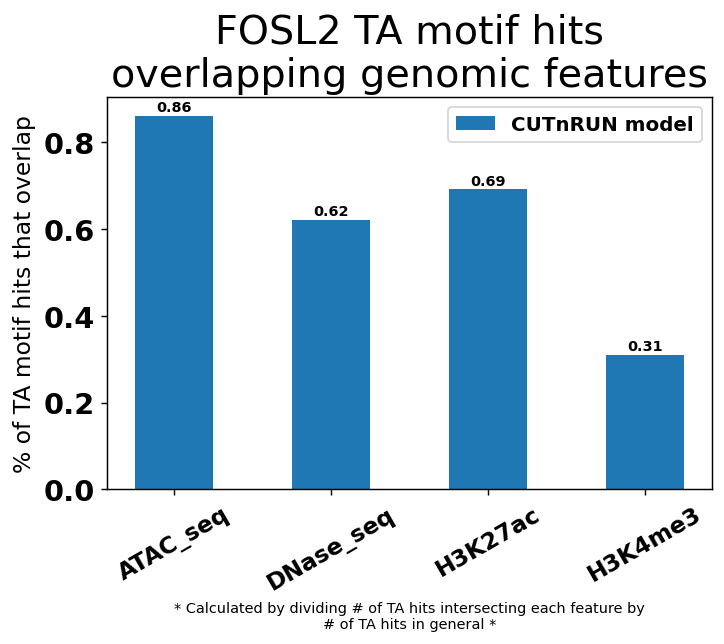

In [133]:
plot_overlaps('FOSL2', 'TA', 'TA')

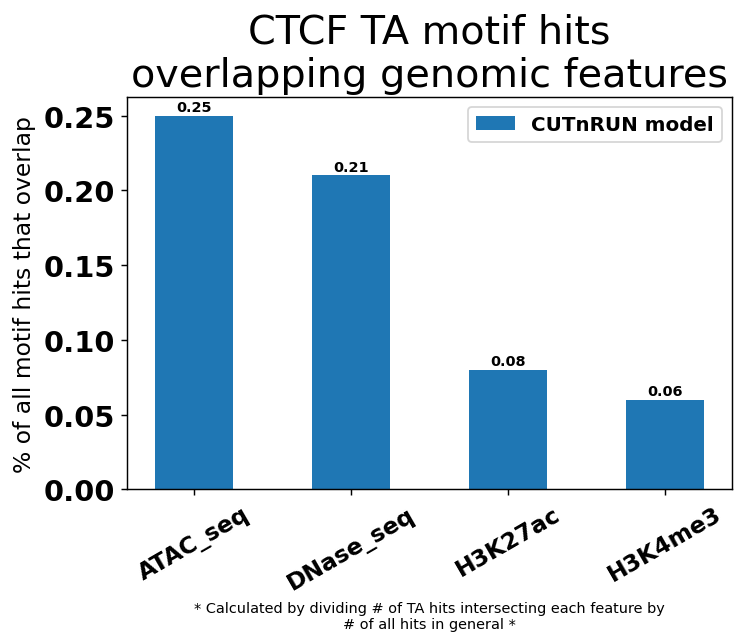

In [135]:
plot_overlaps('CTCF', 'TA', 'all')

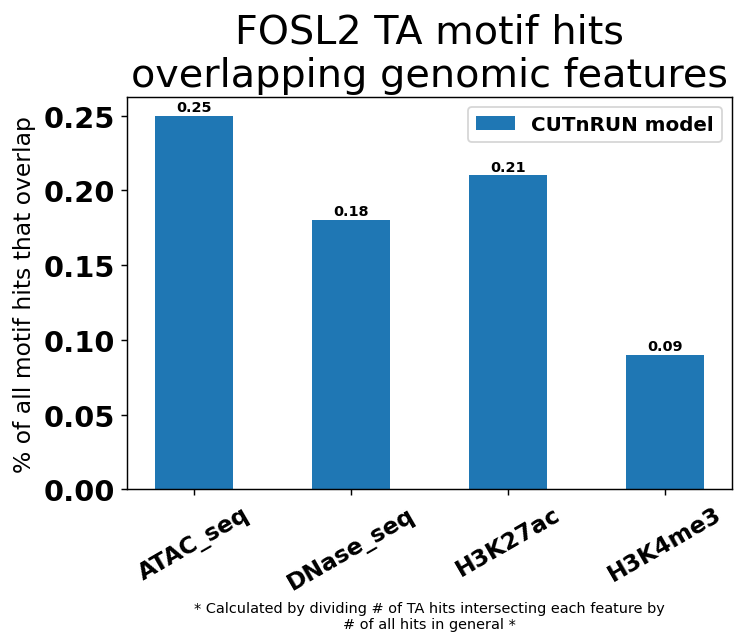

In [134]:
plot_overlaps('FOSL2', 'TA', 'all')